# Obs_precip_TW.ipynb

- This notebook reproduces the following rainfall figures (with rain gauge data over Taiwan) in Guo et al. (2025).
    - Fig. 5
    - Fig. 6(b)(e)
    - Fig. 9(b)
    - Supplementary figures S1 and 9
- **Additional data reminder**:
    - Pre-calculated data have been saved in `/data/processed/demo_data` and `/data/processed/weather_tabel_self/`, so figures in this notebook can be reproduced without additional datasets.
    - If desired, pre-calculated data can be reproduced after downloading CWA rain gauge data at (https://asrad.pccu.edu.tw/) using:
        - Cell section `Function: Calculate composite` for daily composite patterns
        - Function: `weather_table.get_cwb_precip_table()` for daily patterns
        - `/src/main/data_processing/weather_table_self.py` for hourly precipitation
- Execution order of cell sections for reproducing figures: 
    1. `Import`
    2. `Utilities`
    3. Each `Figure: ...`

# Import

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import seaborn.colors.xkcd_rgb as c
from matplotlib.gridspec import GridSpec

# Utilities

## Data

In [3]:
wtab_all      = pd.read_csv(f"../../data/processed/weather_table_self/all_withlv.csv")       # weather table
cond_lv0_all  = (wtab_all['ERA5_all_lv0']>=-4)&(wtab_all['ERA5_all_lv0']<2)                  # six heavy-rainfall-promoting IVT regimes
cond_lv1_all  = (wtab_all['ERA5_all_lv1']>=-4)&(wtab_all['ERA5_all_lv1']<0)

In [4]:
df_up_polar   = pd.read_csv('../../data/processed/weather_table_self/all_polar.csv')         # weather table w/ upstream IVT info.
df_up_polar['IVT_theta'] = df_up_polar['IVT_theta'].mask(df_up_polar['IVT_theta']<0, df_up_polar['IVT_theta']+np.pi*2)
df_polar_6reg = df_up_polar[cond_lv0_all&cond_lv1_all]

In [5]:
topo_fpath = '../../data/raw/vvm_TOPO.nc'   # high-resolution (500m) Taiwan topography

In [6]:
swhpcp_all = pd.read_csv('../../data/processed/weather_table_self/swland_hpcp_all.csv')
swhpcp_all['yyyymmdd'] = pd.to_datetime(swhpcp_all['yyyymmdd'], format='%Y%m%d')

### !!

In [43]:
pcp_fpath  = ''

## General class and functions

### Class: Plot_analysis()

In [7]:
class Plot_analysis():
    def __init__(self):
        self.proj = ccrs.PlateCarree()
        self.ds_topo = xr.open_dataset(topo_fpath)        
    
    def Axe_map(self, fig, gs, 
                xlim_, ylim_, **grid_info):
        # Set map extent
        axe  = fig.add_subplot(gs, projection=self.proj)
        axe.set_extent([xlim_[0], xlim_[-1], ylim_[0], ylim_[-1]], crs=self.proj)
        # Set additional grid information
        if len(grid_info)>0:
            if grid_info['xloc_'] is not None:
                axe.set_xticks(grid_info['xloc_'], crs=self.proj)
                axe.set_xticklabels(['' for i in range(len(grid_info['xloc_']))])  # default: no tick labels
            if grid_info['yloc_'] is not None:
                axe.set_yticks(grid_info['yloc_'], crs=self.proj)
                axe.set_yticklabels(['' for i in range(len(grid_info['yloc_']))])
            gl = axe.gridlines(xlocs=grid_info['xloc_'], ylocs=grid_info['yloc_'], 
                               draw_labels=False)
        return axe
    
    def Plot_cartopy_map(self, axe):
        axe.add_feature(cfeature.LAND,color='grey',alpha=0.1)
        axe.coastlines(resolution='50m', color='black', linewidth=1)
        return axe
    
    def Plot_vvm_map(self, axe, color, linewidth):
        axe.contour(self.ds_topo.lon, self.ds_topo.lat, self.ds_topo.TOPO, 
                    levels=np.array([-1e-3, 1e-3]), 
                    colors=color, linewidths=linewidth)
    
    def Plot_vvm_topo(self, axe, color, linewidth=None):
        topo_bounds= np.arange(0, 3500.1, 500)
        alpha_list = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
        cmap_topo  = colors.ListedColormap([(0, 0, 0, i) for i in alpha_list])
        norm_      = colors.BoundaryNorm(topo_bounds, cmap_topo.N, extend='max')
        imtopoh    = axe.contourf(self.ds_topo.lon, self.ds_topo.lat, self.ds_topo.TOPO*1e2, 
                                  levels=topo_bounds, 
                                  cmap=cmap_topo, norm=norm_, extend='max', antialiased=1)
        if linewidth is not None:
            axe.contour(self.ds_topo.lon, self.ds_topo.lat, self.ds_topo.TOPO*1e2, levels=np.array([499.99, 500.01]), 
                        colors=color, linewidths=linewidth)
        else:
            pass
        return imtopoh
        
    def Plot_twcwb_pcp(self, axe, 
                       lon, lat, precip,
                       s, alpha, precip_bounds=[1, 2, 6, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 300], edgecolors=None):
        bounds= np.array(precip_bounds)
        cmap  = cmaps.WhiteBlueGreenYellowRed
        norm  = colors.BoundaryNorm(bounds, cmap.N, extend='both')
        im    = axe.scatter(lon, lat, c=precip, s=s, 
                            cmap=cmap, norm=norm, alpha=alpha, edgecolors=edgecolors)
        return im
    
plottools = Plot_analysis()

### Class: weather table()

In [8]:
class weather_table():
    def __init__(self, year_list:list, month_list:list, 
                 special_start_date:str=False, special_end_date:str=False, 
                 lat_range=(None, None), lon_range=(None, None)):
        self.YEARS     = year_list
        self.MONTHS    = month_list
        self.STARTDATE = self._convert_to_dobj(special_start_date) if special_start_date else None
        self.ENDDATE   = self._convert_to_dobj(special_end_date) if special_end_date else None
        self.LATRANGE  = lat_range if lat_range[0]>lat_range[1] and \
                         lat_range[0] is not None and lat_range[1] is not None \
                         else lat_range[::-1]  # for ERA5 data
        self.LONRANGE  = lon_range
    
    def _convert_to_dobj(self, date):
        """
        Convert a date string into a datetime object.
        Two types of string format are supported: 20051218 or 2005-12-18.
        """
        if isinstance(date, str):
            if len(date)>8:
                dateobj = datetime.strptime(date, '%Y-%m-%d')
            else:
                dateobj = datetime.strptime(date, '%Y%m%d')
        else:
            dateobj = date
        return dateobj

    
    def get_cwb_precip_table(self, date:str, accumulate_daily=False):
        # File list
        cwb_fpath = f'{pcp_fpath}/{date[:4]}/{date[4:6]}/{date}'
        cwb_flist = sorted(glob.glob(f'{cwb_fpath}/{date}*'))
        # Define column widths based on README
        col_widths = [7, 10, 9, 7, 7, 7, 7, 7, 7, 7, 7, 3]
        # Define the column names
        col_names = ['stno', 'lon', 'lat', 'elv', 'PS', 'T', 'RH',
                     'WS', 'WD', 'PP', 'odSS01', 'ojits']
        # Use read_fwf to read the fixed-width formatted file
        for hh in range(len(cwb_flist)):
            data = pd.read_fwf(cwb_flist[hh], widths=col_widths, names=col_names)
            cwb_lon, cwb_lat, cwb_pcp = data[['lon', 'lat', 'PP']].values.T
            self.cwb_LON = cwb_lon
            self.cwb_LAT = cwb_lat
            
            if accumulate_daily:                              # target_pcp is daily precip.
                if hh<1:
                    target_pcp = cwb_pcp
                else:
                    target_pcp = np.add(target_pcp, cwb_pcp)
                
            else:                                            # target_pcp is hourly precip.
                if hh<1:
                    target_pcp= cwb_pcp[np.newaxis, ...]
                else:
                    target_pcp= np.concatenate((target_pcp, cwb_pcp[np.newaxis, ...]), axis=0)
        target_pcp    = np.where(target_pcp>=0., target_pcp, np.nan)
        if accumulate_daily:
            pcp_table = pd.DataFrame({'stn_lon':cwb_lon, 'stn_lat':cwb_lat, 'precip':target_pcp})
        else:
            raise ValueError("Table for hourly precipitation isn't built yet.")
        return pcp_table
                
wtab_module_all  = weather_table(year_list=np.arange(2001, 2020).tolist(), month_list=np.arange(4, 10).tolist(), 
                                 lat_range=(22, 20), lon_range=(115, 119))

In [9]:
# demo_case = ['20100912', '20120819', '20150828', '20180828', '20190815', '20160610', '20140810', '20170602']
# dict_cwa_pcp_demo = {}
# for dd in demo_case:
#     pcp_table = wtab_module_all.get_cwb_precip_table(dd, accumulate_daily=True)
#     dict_cwa_pcp_demo['stn_lon'] = pcp_table['stn_lon'].values
#     dict_cwa_pcp_demo['stn_lat'] = pcp_table['stn_lat'].values
#     dict_cwa_pcp_demo[dd] = pcp_table['precip'].values

In [10]:
# np.save('../../data/processed/demo_data/cwa_pcp_demo_case.npy', dict_cwa_pcp_demo)

In [11]:
dict_cwa_pcp_demo = np.load('../../data/processed/demo_data/cwa_pcp_demo_case.npy', allow_pickle=True).item()

### Function: Calculate composite

In [12]:
def Cal_cwa_dpcp_comp(datelist:list, pcp_filter_min=0.):
    for i, dd in enumerate(datelist):
        # Data initialize
        if i < 1:
            pcp_table = wtab_module_all.get_cwb_precip_table(str(dd), accumulate_daily=True)
            pcp_comp  = pcp_table['precip'].values[:, np.newaxis]
        else:
            temp = wtab_module_all.get_cwb_precip_table(str(dd), accumulate_daily=True)['precip'].values
            pcp_comp  = np.concatenate((pcp_comp, temp[:, np.newaxis]), axis=1)
    print(pcp_comp.shape)
    daily_max = np.nanmax(pcp_comp, axis=0)
    mask      = daily_max>pcp_filter_min
    print(pcp_comp[..., mask].shape)
    mean_pcp  = np.nanmean(pcp_comp[..., mask], axis=1)
    return pcp_table['stn_lon'], pcp_table['stn_lat'], mean_pcp

In [13]:
dlist_3477    = wtab_all['yyyymmdd'].to_list()

In [14]:
# stn_lon, stn_lat, mean_pcp_3477 = Cal_cwa_dpcp_comp(datelist=dlist_3477)

In [15]:
# strong_cond    = (df_polar_6reg['IVT_r']>=250)&(df_polar_6reg['IVT_theta']>=np.deg2rad(200))&(df_polar_6reg['IVT_theta']<=np.deg2rad(280))
# dlist_6reg_sswf= df_polar_6reg[strong_cond]['yyyymmdd'].to_list()

In [16]:
# stn_lon, stn_lat, mean_pcp_6reg_sswf = Cal_cwa_dpcp_comp(datelist=dlist_6reg_sswf)

In [17]:
# dlist_6reg_nosswf= df_polar_6reg[~strong_cond]['yyyymmdd'].to_list()
# print(len(dlist_6reg_nosswf))

In [18]:
# stn_lon, stn_lat, mean_pcp_6reg_nosswf = Cal_cwa_dpcp_comp(datelist=dlist_6reg_nosswf)

In [19]:
# dict_cwa_pcp_comp = {'stn_lon':stn_lon.values, 'stn_lat':stn_lat.values,
#                      'sw_datelist':dlist_6reg_sswf, 'at_datelist':dlist_6reg_nosswf,
#                      'all_comp':mean_pcp_3477, 'sw_comp':mean_pcp_6reg_sswf, 'at_comp':mean_pcp_6reg_nosswf}
# np.save('../../data/processed/demo_data/cwa_pcp_comp.npy', dict_cwa_pcp_comp)

In [20]:
dict_cwa_pcp_comp = np.load('../../data/processed/demo_data/cwa_pcp_comp.npy', allow_pickle=True).item()

# Figure: Composite

In [27]:
def Plot_cwb_comp_add_settings(rainfall_label:str, precip_array, figtitle=False):
    if rainfall_label=='strong':
        bounds    = np.array([2, 5, 10, 15, 25, 40, 50, 70, 90])
        alpha     = 0.8
    elif rainfall_label=='weak':
        bounds    = np.array([2, 5, 10, 15, 25])
        alpha     = 0.85
    # Figure initialize
    fig = plt.figure(figsize=(4, 8))
    gs  = GridSpec(1, 1, figure=fig)
    ## Plot:
    ax1   = plottools.Axe_map(fig, gs[0], xlim_=[119.95, 122.05], ylim_=[21.85, 25.5], 
                              xloc_=np.arange(120, 122.1, 1), yloc_=np.arange(22, 25.1, 1))
    plottools.Plot_vvm_map(ax1, c['dark grey'], 1.5)  # coastline
    temp = np.argsort(precip_array)
    imcwb = plottools.Plot_twcwb_pcp(ax1, 
                                     dict_cwa_pcp_comp['stn_lon'][temp], 
                                     dict_cwa_pcp_comp['stn_lat'][temp], 
                                     precip_array[temp], s=75, alpha=alpha, precip_bounds=bounds)
    cax  = fig.add_axes([ax1.get_position().x1+0.06, ax1.get_position().y0, 0.03, ax1.get_position().height])
    cbar = fig.colorbar(imcwb, orientation='vertical', cax=cax)
    cbar.solids.set(alpha=1)  # Default: set cbar to full color (w/out tranparency)
    cbar.set_ticks(ticks=bounds, labels=[int(i) for i in bounds])
    cbar.set_label('mm/day', fontsize=16)
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_linewidth(1.5)

    topo_bounds= np.arange(0, 3500.1, 500)
    imtopoh    = plottools.Plot_vvm_topo(ax1, c['dark grey'], 0.5)
    cax  = fig.add_axes([ax1.get_position().x0,ax1.get_position().y0-0.06, ax1.get_position().width, 0.015])
    cbar = fig.colorbar(imtopoh, orientation='horizontal', cax=cax, extend='max')
    cbar.set_ticks(ticks=topo_bounds, labels=[f"{i/1e3:.1f}" for i in topo_bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('Topography Height (km)', fontsize=16)
    cbar.outline.set_linewidth(1.5)

    ax1.set_xticklabels([f'{int(i)}\N{DEGREE SIGN} E' for i in np.arange(120, 122.1, 1)], fontsize=16)
    ax1.set_yticklabels([f'{int(i)}\N{DEGREE SIGN} N' for i in np.arange(22, 25.1, 1)], fontsize=16)
    if figtitle:
        ax1.set_title(f'{figtitle}', loc='left', fontsize=20)
    else:
        ax1.set_title('CWA precipitation', fontsize=16)
        fig.suptitle(x=0.5, y=0.91, t='Composite [6 Reg.+SSWF]', fontsize=18, fontweight='bold')
    plt.show()

## Fig. S1 (3477 days)

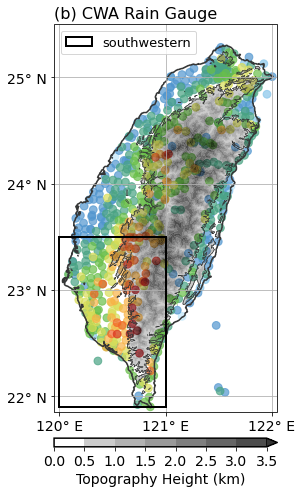

In [25]:
bounds = [1]+np.arange(2.5, 25.1, 2.5).tolist()
# Figure initialize
fig = plt.figure(figsize=(4, 8))
gs  = GridSpec(1, 1, figure=fig)
## Plot:
ax1   = plottools.Axe_map(fig, gs[0], xlim_=[119.95, 122.05], ylim_=[21.85, 25.5], 
                          xloc_=np.arange(120, 122.1, 1), yloc_=np.arange(22, 25.1, 1))
plottools.Plot_vvm_map(ax1, c['dark grey'], 1.5)  # coastline
temp = np.argsort(dict_cwa_pcp_comp['all_comp'])
imcwb = plottools.Plot_twcwb_pcp(ax1, 
                                 dict_cwa_pcp_comp['stn_lon'][temp], 
                                 dict_cwa_pcp_comp['stn_lat'][temp], 
                                 dict_cwa_pcp_comp['all_comp'][temp], 
                                 s=60, alpha=0.7, precip_bounds=bounds)

topo_bounds= np.arange(0, 3500.1, 500)
imtopoh    = plottools.Plot_vvm_topo(ax1, c['dark grey'], 0.5)
cax  = fig.add_axes([ax1.get_position().x0,ax1.get_position().y0-0.06, ax1.get_position().width, 0.015])
cbar = fig.colorbar(imtopoh, orientation='horizontal', cax=cax, extend='max')
cbar.set_ticks(ticks=topo_bounds, labels=[f"{(i/1e3):.1f}" for i in topo_bounds])
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Topography Height (km)', fontsize=14)
cbar.outline.set_linewidth(1.5)

rect = patches.Rectangle((120, 21.9), 1, 1.6, fc="none", ec=c['black'], linewidth=2, zorder=50, label='southwestern')
ax1.add_artist(rect)
ax1.legend(handles=[rect], fontsize=13, loc='upper left')

ax1.set_xticklabels([f'{int(i)}\N{DEGREE SIGN} E' for i in np.arange(120, 122.1, 1)], fontsize=14)
ax1.set_yticklabels([f'{int(i)}\N{DEGREE SIGN} N' for i in np.arange(22, 25.1, 1)], fontsize=14)
ax1.set_title('(b) CWA Rain Gauge', fontsize=16, loc='left')
plt.show()

## Fig. 6e (505 days)

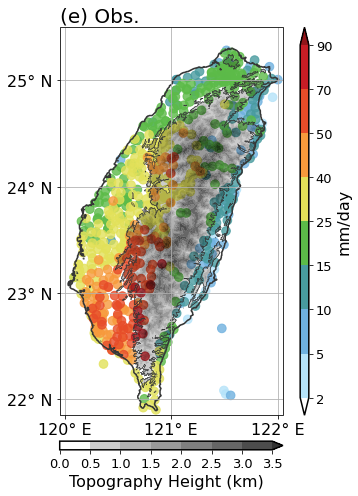

In [28]:
Plot_cwb_comp_add_settings(rainfall_label='strong', precip_array=dict_cwa_pcp_comp['sw_comp'], figtitle='(e) Obs.')

## Fig. 6b (1542 days)

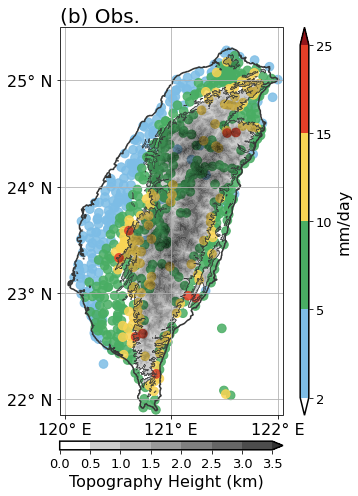

In [29]:
Plot_cwb_comp_add_settings(rainfall_label='weak', precip_array=dict_cwa_pcp_comp['at_comp'], figtitle='(b) Obs.')

# Figure: Individual cases

In [44]:
def Plot_cwa_dpcp_add_settings(date:str, pcp_max='all', regional_rect=False, figtitle=False):
    # Data initialize
    # pcp_table = wtab_module_all.get_cwb_precip_table(date, accumulate_daily=True)
    # if pcp_max == 'sw':
    #     pcp_max   = pcp_table[(pcp_table['stn_lon']>=120)&\
    #                           (pcp_table['stn_lon']<=121)&\
    #                           (pcp_table['stn_lat']>=21.9)&\
    #                           (pcp_table['stn_lat']<=23.5)]['precip'].max(skipna=True)
    # else:
    #     pcp_max   = pcp_table['precip'].max(skipna=True)
    if pcp_max == 'sw':
        pcp_temp  = np.where((dict_cwa_pcp_demo['stn_lon']>=120)&\
                             (dict_cwa_pcp_demo['stn_lon']<=121)&\
                             (dict_cwa_pcp_demo['stn_lat']>=21.9)&\
                             (dict_cwa_pcp_demo['stn_lat']<=23.5), dict_cwa_pcp_demo[date], np.nan)
        pcp_max   = np.nanmax(pcp_temp)
    else:
        pcp_max   = np.nanmax(dict_cwa_pcp_demo[date])
    bounds    = np.array([1, 2, 6, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 300])
    # Figure initialize
    fig = plt.figure(figsize=(4, 8))
    gs  = GridSpec(1, 1, figure=fig)
    ## Plot:
    ax1   = plottools.Axe_map(fig, gs[0], xlim_=[119.95, 122.05], ylim_=[21.85, 25.5], 
                              xloc_=np.arange(120, 122.1, 1), yloc_=np.arange(22, 25.1, 1))
    plottools.Plot_vvm_map(ax1, c['dark grey'], 1.5)  # coastline
    # temp1 = np.argsort(pcp_table['precip'].values)
    # imcwb = plottools.Plot_twcwb_pcp(ax1, pcp_table['stn_lon'].iloc[temp1], pcp_table['stn_lat'].iloc[temp1], pcp_table['precip'].iloc[temp1], s=80, alpha=0.8, precip_bounds=bounds)
    temp1 = np.argsort(dict_cwa_pcp_demo[date])
    imcwb = plottools.Plot_twcwb_pcp(ax1, 
                                     dict_cwa_pcp_demo['stn_lon'][temp1], 
                                     dict_cwa_pcp_demo['stn_lat'][temp1], 
                                     dict_cwa_pcp_demo[date][temp1], 
                                     s=80, alpha=0.8, precip_bounds=bounds)
    
    cax  = fig.add_axes([ax1.get_position().x1+0.28, ax1.get_position().y0, 0.03, ax1.get_position().height])
    cbar = fig.colorbar(imcwb, orientation='vertical', cax=cax)
    cbar.solids.set(alpha=1)  # Default: set cbar to full color (w/out tranparency)
    cbar.set_ticks(ticks=bounds, labels=[int(i) for i in bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('mm/day', fontsize=16)
    cbar.outline.set_linewidth(1.5)
    
    topo_bounds= np.arange(0, 3500.1, 500)
    imtopoh    = plottools.Plot_vvm_topo(ax1, c['dark grey'], 0.5)
    cax  = fig.add_axes([ax1.get_position().x1+0.04, ax1.get_position().y0, 0.03, ax1.get_position().height])
    cbar = fig.colorbar(imtopoh, orientation='vertical', cax=cax)
    cbar.set_ticks(ticks=topo_bounds, labels=[f"{i/1e3:.1f}" for i in topo_bounds])
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label('Topography Height (km)', fontsize=16)
    cbar.outline.set_linewidth(1.5)
    
    ax1.text(x=120, y=25.3, s=f'Max: {pcp_max:.1f} (mm/day)', fontsize=15)
    ax1.set_xticklabels([f'{int(i)}\N{DEGREE SIGN} E' for i in np.arange(120, 122.1, 1)], fontsize=16)
    ax1.set_yticklabels([f'{int(i)}\N{DEGREE SIGN} N' for i in np.arange(22, 25.1, 1)], fontsize=16)
    if regional_rect:
        rect = patches.Rectangle((regional_rect[0], regional_rect[2]), regional_rect[1]-regional_rect[0], regional_rect[3]-regional_rect[2], 
                                 fc="none", ec=c['black'], linewidth=2, zorder=50, label='south-\nwestern')
        ax1.add_artist(rect)
        ax1.legend(handles=[rect], fontsize=13, loc='lower right')
    if figtitle:
        ax1.set_title(f'{figtitle}', loc='left', fontsize=20)
    else:
        ax1.set_title('CWA precipitation', fontsize=16)
        fig.suptitle(x=0.5, y=0.91, t=date, fontsize=18, fontweight='bold')
    plt.show()

## Fig. 5a & 5b

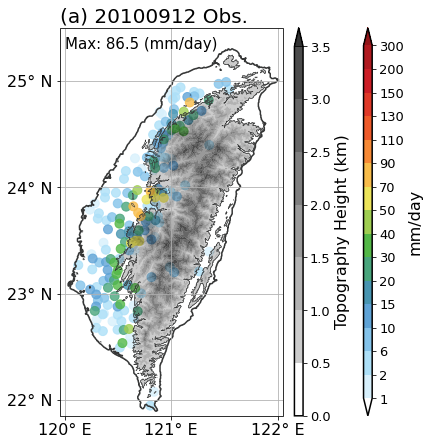

In [45]:
Plot_cwa_dpcp_add_settings('20100912', figtitle='(a) 20100912 Obs.')

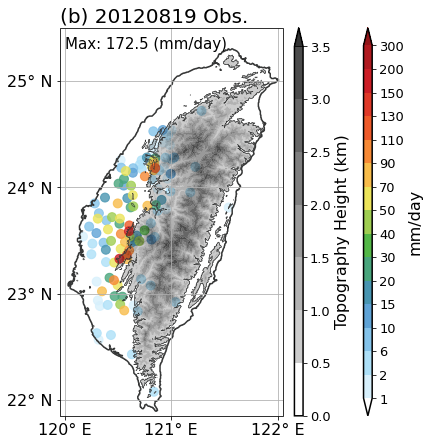

In [46]:
Plot_cwa_dpcp_add_settings('20120819', figtitle='(b) 20120819 Obs.')

## Fig. 5c–5e

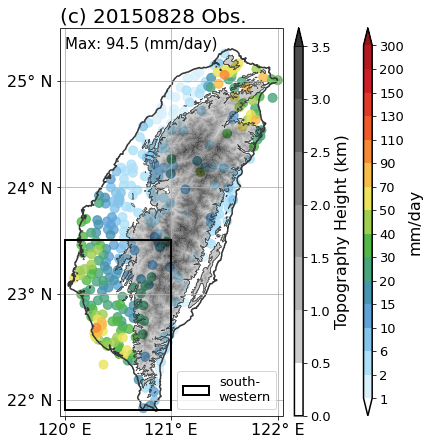

In [47]:
Plot_cwa_dpcp_add_settings('20150828', pcp_max='sw', regional_rect=(120, 121, 21.9, 23.5), figtitle='(c) 20150828 Obs.')

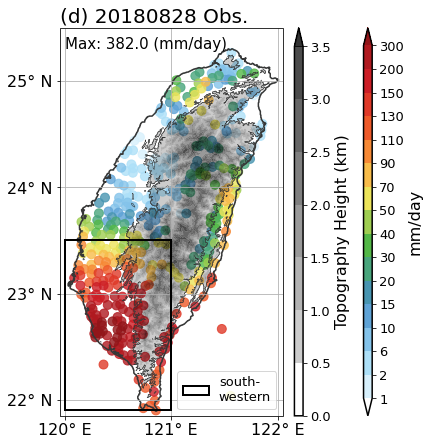

In [48]:
Plot_cwa_dpcp_add_settings('20180828', pcp_max='sw', regional_rect=(120, 121, 21.9, 23.5), figtitle='(d) 20180828 Obs.')

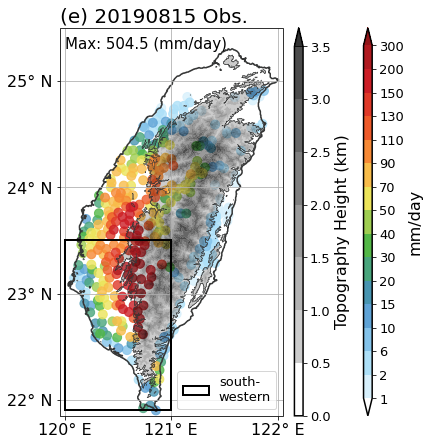

In [49]:
Plot_cwa_dpcp_add_settings('20190815', pcp_max='sw', regional_rect=(120, 121, 21.9, 23.5), figtitle='(e) 20190815 Obs.')

## Fig. S9

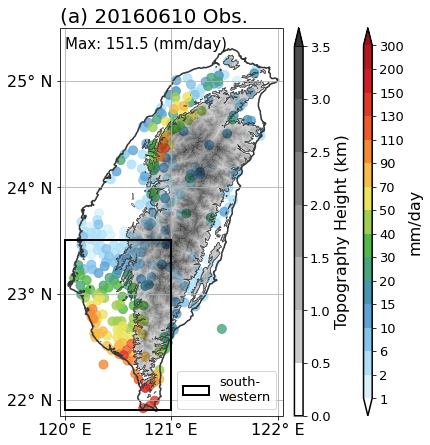

In [50]:
Plot_cwa_dpcp_add_settings('20160610', pcp_max='sw', regional_rect=(120, 121, 21.9, 23.5), figtitle='(a) 20160610 Obs.')

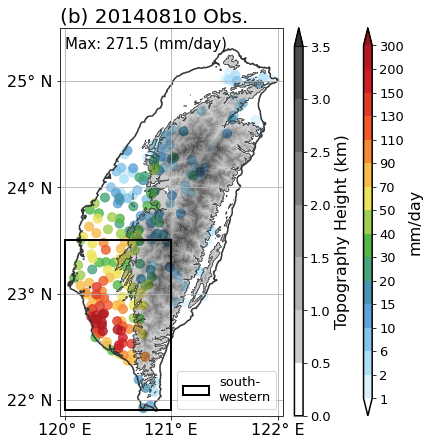

In [51]:
Plot_cwa_dpcp_add_settings('20140810', pcp_max='sw', regional_rect=(120, 121, 21.9, 23.5), figtitle='(b) 20140810 Obs.')

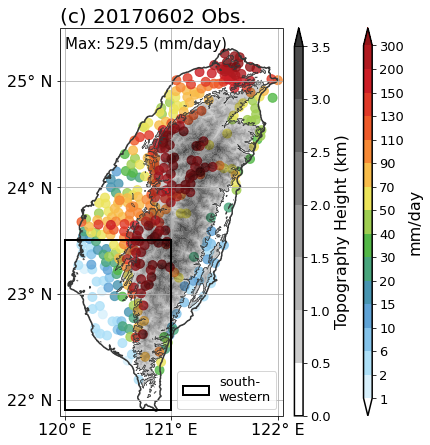

In [52]:
Plot_cwa_dpcp_add_settings('20170602', pcp_max='sw', regional_rect=(120, 121, 21.9, 23.5), figtitle='(c) 20170602 Obs.')

# Figure: SW-land precip. diurnal cycle

In [40]:
dobj_6reg_sswf = pd.to_datetime(dict_cwa_pcp_comp['sw_datelist'], format='%Y%m%d')
dobj_6reg_nosswf = pd.to_datetime(dict_cwa_pcp_comp['at_datelist'], format='%Y%m%d')

In [41]:
# Daily diurnal cycle
swhpcp_6reg_sswf      = swhpcp_all[swhpcp_all['yyyymmdd'].isin(dobj_6reg_sswf)]
swhpcp_6reg_nosswf    = swhpcp_all[swhpcp_all['yyyymmdd'].isin(dobj_6reg_nosswf)]
# Composite diurnal cycle
hpcp_mean_6reg_sswf   = swhpcp_6reg_sswf.drop(columns=['yyyymmdd']).mean(axis=0).values
hpcp_mean_6reg_nosswf = swhpcp_6reg_nosswf.drop(columns=['yyyymmdd']).mean(axis=0).values

## Fig. 9b

Text(0.0, 1.0, '(b) Diurnal structure (composite)')

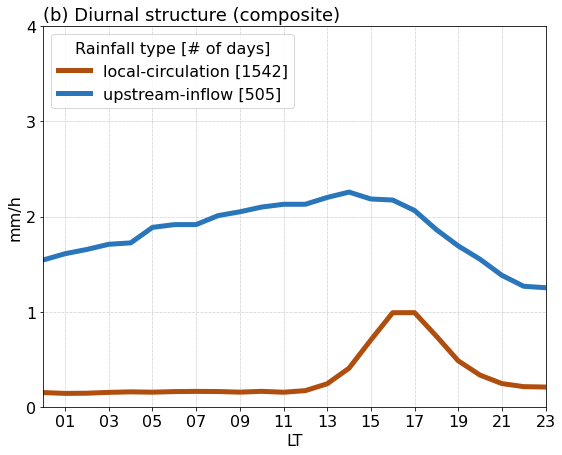

In [42]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(np.arange(24), hpcp_mean_6reg_nosswf, color=c['burnt sienna'], linewidth=5, label=f'local-circulation [{len(dobj_6reg_nosswf)}]')
ax.plot(np.arange(24), hpcp_mean_6reg_sswf, color=c['bluish'], linewidth=5, label=f'upstream-inflow [{len(dobj_6reg_sswf)}]')
# settings
ax.grid(linestyle=':', linewidth=0.5, color='grey')
ax.set_xlim(0, 23)
ax.set_xticks(np.arange(1, 24, 2))
ax.set_xticklabels([f"{i:02d}" for i in range(1, 24, 2)], fontsize=16)
ax.set_xlabel('LT', fontsize=16)
ax.set_ylim(0, 4)
ax.set_yticks(np.arange(5))
ax.set_yticklabels([f"{int(i)}" for i in range(5)], fontsize=16)
ax.set_ylabel('mm/h', fontsize=16)
ax.legend(title='Rainfall type [# of days]',title_fontsize=16, loc='upper left', fontsize=16)
ax.set_title('(b) Diurnal structure (composite)', fontsize=18, loc='left')